## 1. Import Libraries

In [1]:
import numpy as np

import pandas as pd

import sklearn

from sklearn.base import BaseEstimator,TransformerMixin

from sklearn.metrics.pairwise import rbf_kernel

from sklearn.pipeline import (
        Pipeline,
        FeatureUnion
)

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import (
        OneHotEncoder,
        MinMaxScaler,
        PowerTransformer,
        FunctionTransformer,
        StandardScaler,
        OrdinalEncoder
)

from feature_engine.encoding import (
        RareLabelEncoder,
        MeanEncoder,
        CountFrequencyEncoder
)

from feature_engine.datetime import DatetimeFeatures

from feature_engine.outliers import Winsorizer

from feature_engine.selection import SelectBySingleFeaturePerformance

import matplotlib.pyplot as plt

import warnings

## 2. Display Setting

In [2]:
pd.options.display.max_columns=None

In [3]:
sklearn.set_config(transform_output='pandas')

In [4]:
warnings.filterwarnings('ignore')

## 3. Read the train data

In [5]:
train = pd.read_csv('train.csv')
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-Flight Meal Not Included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-Flight Meal Not Included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-Flight Meal Not Included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-Flight Meal Not Included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6694 non-null   float64
 8   additional_info  6695 non-null   object 
 9   price            6695 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.2+ KB


In [7]:
X_train = train.drop(columns='price')
y_train = train['price'].copy()

In [8]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

## 4. Transformation Operations
### 4.1 airline

In [9]:
X_train.airline

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6695, dtype: object

In [10]:
airline_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('grouper',RareLabelEncoder(tol=0.1,replace_with='other',n_categories=2)),
    ('encoder',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

airline_transformer.fit_transform(X_train.loc[:,['airline']])#.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0
6691,1.0,0.0,0.0,0.0,0.0
6692,0.0,0.0,1.0,0.0,0.0
6693,0.0,0.0,0.0,0.0,1.0


`SimpleImputer` is used to `replace missing values` (often represented by NaN) in your data with a certain strategy.
When `strategy='most_frequent'`, the imputer replaces missing values in each column with the most frequent value that appears in that particular column.

`tol (float):` This is the tolerance threshold (between 0 and 1). Categories with a frequency below this proportion of the total data will be considered rare.

When `sparse_output=True (default)`, the encoder returns a sparse matrix. This is a memory-efficient way to represent data with many categories and a high number of zeros. It only stores the non-zero elements and their corresponding indices.

When `sparse_output=False`, the encoder returns a dense array (like a NumPy array). This is easier to work with for some algorithms but can consume more memory, especially for datasets with many categories.

`handle_unknown='ignore'`
This tells the encoder how to handle categories during transformation (encoding) that it hasn't seen during the fitting process (training on the data).
With 'ignore', the encoder creates a new column for the unseen category but sets all its values to 0 in the encoded data.

### 4.2 date_of_journey

In [11]:
X_train.date_of_journey

0       2019-03-21
1       2019-03-27
2       2019-03-09
3       2019-06-12
4       2019-03-12
           ...    
6690    2019-03-21
6691    2019-05-01
6692    2019-06-01
6693    2019-06-24
6694    2019-03-01
Name: date_of_journey, Length: 6695, dtype: object

In [12]:
feature_to_extract = ['month','week','day_of_week','day_of_year']

doj_transformer = Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=feature_to_extract,yearfirst=True,format='mixed')),
    ('scaler',MinMaxScaler())
])


doj_transformer.fit_transform(X_train.loc[:,['date_of_journey']])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.176471,0.500000,0.169492
1,0.000000,0.235294,0.333333,0.220339
2,0.000000,0.058824,0.833333,0.067797
3,1.000000,0.882353,0.333333,0.872881
4,0.000000,0.117647,0.166667,0.093220
...,...,...,...,...
6690,0.000000,0.176471,0.500000,0.169492
6691,0.666667,0.529412,0.333333,0.516949
6692,1.000000,0.764706,0.833333,0.779661
6693,1.000000,1.000000,0.000000,0.974576


### 4.3 source & destination

In [13]:
X_train.source

0       Banglore
1          Delhi
2       Banglore
3        Kolkata
4       Banglore
          ...   
6690       Delhi
6691     Kolkata
6692       Delhi
6693       Delhi
6694    Banglore
Name: source, Length: 6695, dtype: object

In [14]:
X_train.destination

0       New Delhi
1          Cochin
2       New Delhi
3        Banglore
4       New Delhi
          ...    
6690       Cochin
6691     Banglore
6692       Cochin
6693       Cochin
6694    New Delhi
Name: destination, Length: 6695, dtype: object

In [15]:
location_subset = X_train.loc[:,['source','destination']]
location_subset

,source,destination
0,Banglore,New Delhi
1,Delhi,Cochin
2,Banglore,New Delhi
3,Kolkata,Banglore
4,Banglore,New Delhi
...,...,...
6690,Delhi,Cochin
6691,Kolkata,Banglore
6692,Delhi,Cochin
6693,Delhi,Cochin


In [16]:
location_pipe = Pipeline(steps=[
                         ('grouper',RareLabelEncoder(tol=0.1,replace_with='other',n_categories=2)),
                         ('encoder',MeanEncoder()),
                         ('scaler',PowerTransformer())        
])

location_pipe.fit_transform(location_subset,y_train)

,source,destination
0,-0.857930,-0.736484
1,1.065418,1.061694
2,-0.857930,-0.736484
3,-0.203928,-0.224351
4,-0.857930,-0.736484
...,...,...
6690,1.065418,1.061694
6691,-0.203928,-0.224351
6692,1.065418,1.061694
6693,1.065418,1.061694


In [17]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [18]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ['Delhi','Kolkata','Mumbai','New Delhi']
    return (
        X
        .assign(**{
            f"{col}_is_north" : X.loc[:,col].isin(north_cities).astype('int')
            for col in columns
        })
        .drop(columns=columns)
    )


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
...,...,...
6690,1,0
6691,1,0
6692,1,0
6693,1,0


In [19]:
location_transformer = FeatureUnion(transformer_list=[
    ('pipe1',location_pipe),
    ('pipe2',FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset,y_train)

,source,destination,source_is_north,destination_is_north
0,-0.857930,-0.736484,0,1
1,1.065418,1.061694,1,0
2,-0.857930,-0.736484,0,1
3,-0.203928,-0.224351,1,0
4,-0.857930,-0.736484,0,1
...,...,...,...,...
6690,1.065418,1.061694,1,0
6691,-0.203928,-0.224351,1,0
6692,1.065418,1.061694,1,0
6693,1.065418,1.061694,1,0


### 4.4 dep_time & arrival_time

In [20]:
X_train.dep_time

0       08:55:00
1       17:30:00
2       11:40:00
3       09:25:00
4       22:55:00
          ...   
6690    10:45:00
6691    09:25:00
6692    14:00:00
6693    07:55:00
6694    11:50:00
Name: dep_time, Length: 6695, dtype: object

In [21]:
X_train.arrival_time

0       19:10:00
1       04:25:00
2       14:35:00
3       18:30:00
4       07:40:00
          ...   
6690    18:50:00
6691    18:30:00
6692    19:00:00
6693    13:25:00
6694    08:55:00
Name: arrival_time, Length: 6695, dtype: object

In [22]:
time_subset = X_train.loc[:,['dep_time','arrival_time']]
time_subset

,dep_time,arrival_time
0,08:55:00,19:10:00
1,17:30:00,04:25:00
2,11:40:00,14:35:00
3,09:25:00,18:30:00
4,22:55:00,07:40:00
...,...,...
6690,10:45:00,18:50:00
6691,09:25:00,18:30:00
6692,14:00:00,19:00:00
6693,07:55:00,13:25:00


In [23]:
time_pipe1 = Pipeline(steps=[
    ('dt',DatetimeFeatures(features_to_extract=['hour','minute'])),
    ('scaler',MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,1.000000,0.826087,0.181818
1,0.739130,0.545455,0.173913,0.454545
2,0.478261,0.727273,0.608696,0.636364
3,0.391304,0.454545,0.782609,0.545455
4,0.956522,1.000000,0.304348,0.727273
...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091
6691,0.391304,0.454545,0.782609,0.545455
6692,0.608696,0.000000,0.826087,0.000000
6693,0.304348,1.000000,0.565217,0.454545


In [24]:
def part_of_day(X,morning=4,afternoon=12,evening=16,night=20):
    columns = X.columns.to_list()
    
    X_temp = X.assign(**{
        col : pd.to_datetime(X.loc[:,col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day":np.select(
                [X_temp.loc[:,col].between(morning,afternoon,inclusive='left'),
                X_temp.loc[:,col].between(afternoon,evening,inclusive='left'),
                X_temp.loc[:,col].between(evening,night,inclusive='left')],
                ['morning','afternoon','evening'],
                default='night'
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,evening,morning
2,morning,afternoon
3,morning,evening
4,night,morning
...,...,...
6690,morning,evening
6691,morning,evening
6692,afternoon,evening
6693,morning,afternoon


In [25]:
time_pipe2 = Pipeline(steps=[
    ('part',FunctionTransformer(func=part_of_day)),
    ('encoder',CountFrequencyEncoder()),
    ('scaler',MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.667335
1,0.202685,0.952906
2,1.000000,0.000000
3,1.000000,0.667335
4,0.174101,0.952906
...,...,...
6690,1.000000,0.667335
6691,1.000000,0.667335
6692,0.000000,0.667335
6693,1.000000,0.000000


In [26]:
time_transformer = FeatureUnion(transformer_list=[
    ('pipe1',time_pipe1),
    ('pipe2',time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335
1,0.739130,0.545455,0.173913,0.454545,0.202685,0.952906
2,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000
3,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
4,0.956522,1.000000,0.304348,0.727273,0.174101,0.952906
...,...,...,...,...,...,...
6690,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335
6691,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335
6692,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335
6693,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000


### 4.5 duration

In [27]:
X_train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6695, dtype: int64

In [28]:
duration = X_train.loc[:,['duration']]
duration

,duration
0,615
1,655
2,175
3,545
4,525
...,...
6690,1925
6691,545
6692,300
6693,330


In [29]:
reference_values = (
    X_train
    .duration
    .quantile([0.25,0.5,0.75])
    .values
    .reshape(-1,1)
    #.shape
)

reference_values

array([[170. ],
       [510. ],
       [922.5]])

In [30]:
class RBFPercentileSimilarity(BaseEstimator,TransformerMixin):
   
    def __init__(self,variables=None,percentile=[0.25,0.5,0.75],gamma=0.1):
        self.variables=variables
        self.percentile=percentile
        self.gamma=gamma

    def fit(self,X,y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include='number').columns.to_list()

        self.reference_values = {
            col : (
                X
                .loc[:,col]
                .quantile(self.percentile)
                .values
                .reshape(-1,1)
            )
            for col in self.variables
        }

        return self



    def transform(self,X):
        objects = []

        # create column name.
        for col in self.variables:
            
            columns = [f"{col}_rbf_{int(percentile*100)}" for percentile in self.percentile]

            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:,[col]],Y=self.reference_values[col],gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)

        return pd.concat(objects,axis=1)

In [31]:
RBFPercentileSimilarity().fit_transform(duration)

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,0.000000,0.000000e+00,0.0
1,0.000000,0.000000e+00,0.0
2,0.082085,0.000000e+00,0.0
3,0.000000,6.293989e-54,0.0
4,0.000000,1.691898e-10,0.0
...,...,...,...
6690,0.000000,0.000000e+00,0.0
6691,0.000000,6.293989e-54,0.0
6692,0.000000,0.000000e+00,0.0
6693,0.000000,0.000000e+00,0.0


In [32]:
# convert duration feature into categories

def duration_category(X,short=180,med=420):
    return (
        X
        .assign(
            duration_cat = np.select([(X.duration.lt(short)),
                                      (X.duration.between(short,med,inclusive='left'))],
                                     ['short','medium'],
                                     default='long')
        )
        .drop(columns = 'duration')
    )

In [33]:
FunctionTransformer(func=duration_category).fit_transform(duration)

,duration_cat
0,long
1,long
2,short
3,long
4,long
...,...
6690,long
6691,long
6692,medium
6693,medium


In [34]:
def is_over(X,value=1000):
    return (
        X
        .assign(**{
            f"duration_over_{value}" : X.duration.ge(value).astype('int')
        })
        .drop(columns='duration')
    )

In [35]:
FunctionTransformer(func=is_over).fit_transform(duration)

,duration_over_1000
0,0
1,0
2,0
3,0
4,0
...,...
6690,1
6691,0
6692,0
6693,0


In [36]:
duration_pipe1 = Pipeline(steps=[
    ('rbf',RBFPercentileSimilarity()),
    ('scaler',PowerTransformer())
])


duration_pipe2 = Pipeline(steps=[
    ('category',FunctionTransformer(func=duration_category)),
    ('encoder',OrdinalEncoder(categories=[['short','medium','long']]))
])


duration_union = FeatureUnion(transformer_list=[
    ('part1',duration_pipe1),
    ('part2',duration_pipe2),
    ('part3',FunctionTransformer(func=is_over)),
    ('part4',StandardScaler())
])


duration_transformer = Pipeline(steps=[
    ('outliers',Winsorizer(capping_method='iqr',fold=1.5)),
    ('imputer',SimpleImputer(strategy='median')),
    ('union',duration_union)
])


duration_transformer.fit_transform(duration)

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.364262,-0.107976,-0.107799,2.0,0,-0.033916
1,-0.364262,-0.107976,-0.107799,2.0,0,0.046422
2,2.373008,-0.107976,-0.107799,0.0,0,-0.917631
3,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507
4,-0.364262,-0.107975,-0.107799,2.0,0,-0.214676
...,...,...,...,...,...,...
6690,-0.364262,-0.107976,-0.107799,2.0,1,2.597145
6691,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507
6692,-0.364262,-0.107976,-0.107799,1.0,0,-0.666576
6693,-0.364262,-0.107976,-0.107799,1.0,0,-0.606322


### 4.6 total_stops

In [37]:
X_train.total_stops

0       1.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
6690    2.0
6691    1.0
6692    1.0
6693    1.0
6694    1.0
Name: total_stops, Length: 6695, dtype: float64

In [38]:
def is_direct(X):

    return (

        X
        .assign(
                is_direct_fight = X.total_stops.eq(0).astype(int)
        )
    )

In [39]:
FunctionTransformer(func=is_direct).fit_transform(X_train.loc[:,['total_stops']])

,total_stops,is_direct_fight
0,1.0,0
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
6690,2.0,0
6691,1.0,0
6692,1.0,0
6693,1.0,0


In [40]:
total_stops_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('',FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:,['total_stops']])

,total_stops,is_direct_fight
0,1.0,0
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
6690,2.0,0
6691,1.0,0
6692,1.0,0
6693,1.0,0


### 4.7 additional_info

In [41]:
X_train.additional_info

0       In-Flight Meal Not Included
1       In-Flight Meal Not Included
2                           No Info
3                           No Info
4       In-Flight Meal Not Included
                   ...             
6690                        No Info
6691                        No Info
6692    In-Flight Meal Not Included
6693                        No Info
6694                 1 Long Layover
Name: additional_info, Length: 6695, dtype: object

In [42]:
add_info_pipe1 = Pipeline(steps=[
                ('grp',RareLabelEncoder(tol=0.1,n_categories=2,replace_with='other')),
                ('encoder',OneHotEncoder(handle_unknown='ignore',sparse_output=False))
])

add_info_pipe1.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-Flight Meal Not Included,additional_info_No Info,additional_info_other
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,1.0,0.0,0.0
6693,0.0,1.0,0.0


In [43]:
def have_info(X):
    return (
        X
        .assign(additional_info = X.additional_info.ne('No Info').astype(int))
    )


FunctionTransformer(func=have_info).fit_transform(X_train.loc[:,['additional_info']])#.value_counts()

,additional_info
0,1
1,1
2,0
3,0
4,1
...,...
6690,0
6691,0
6692,1
6693,0


In [44]:
info_union = FeatureUnion(transformer_list=[
    ('part1',add_info_pipe1),
    ('part2',FunctionTransformer(func=have_info))
])

In [45]:
add_info_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='unknown')),
    ('union',info_union)
])

add_info_transformer.fit_transform(X_train.loc[:,['additional_info']])

,additional_info_In-Flight Meal Not Included,additional_info_No Info,additional_info_other,additional_info
0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,1.0,0.0,0.0,1
...,...,...,...,...
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,1.0,0.0,0.0,1
6693,0.0,1.0,0.0,0


## 5. Column Transformer

In [46]:
col_transform = ColumnTransformer(transformers=[
    ('air',airline_transformer,['airline']),
    ('doj',doj_transformer,['date_of_journey']),
    ('location',location_transformer,['source','destination']),
    ('time',time_transformer,['dep_time','arrival_time']),
    ('duration',duration_transformer,['duration']),
    ('stops',total_stops_transformer,['total_stops']),
    ('info',add_info_transformer,['additional_info'])
],remainder='passthrough')

col_transform.fit_transform(X_train,y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,duration__duration_rbf_25,duration__duration_rbf_50,duration__duration_rbf_75,duration__duration_cat,duration__duration_over_1000,duration__duration,stops__total_stops,stops__is_direct_fight,info__additional_info_In-Flight Meal Not Included,info__additional_info_No Info,info__additional_info_other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.857930,-0.736484,0,1,0.347826,1.000000,0.826087,0.181818,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.033916,1.0,0,1.0,0.0,0.0,1
1,0.0,0.0,1.0,0.0,0.0,0.000000,0.235294,0.333333,0.220339,1.065418,1.061694,1,0,0.739130,0.545455,0.173913,0.454545,0.202685,0.952906,-0.364262,-0.107976,-0.107799,2.0,0,0.046422,1.0,0,1.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1.0,0.000000,0.058824,0.833333,0.067797,-0.857930,-0.736484,0,1,0.478261,0.727273,0.608696,0.636364,1.000000,0.000000,2.373008,-0.107976,-0.107799,0.0,0,-0.917631,0.0,1,0.0,1.0,0.0,0
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.872881,-0.203928,-0.224351,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507,1.0,0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.166667,0.093220,-0.857930,-0.736484,0,1,0.956522,1.000000,0.304348,0.727273,0.174101,0.952906,-0.364262,-0.107975,-0.107799,2.0,0,-0.214676,1.0,0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.065418,1.061694,1,0,0.434783,0.818182,0.782609,0.909091,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,1,2.597145,2.0,0,0.0,1.0,0.0,0
6691,1.0,0.0,0.0,0.0,0.0,0.666667,0.529412,0.333333,0.516949,-0.203928,-0.224351,1,0,0.391304,0.454545,0.782609,0.545455,1.000000,0.667335,-0.364262,-0.107976,-0.107799,2.0,0,-0.174507,1.0,0,0.0,1.0,0.0,0
6692,0.0,0.0,1.0,0.0,0.0,1.000000,0.764706,0.833333,0.779661,1.065418,1.061694,1,0,0.608696,0.000000,0.826087,0.000000,0.000000,0.667335,-0.364262,-0.107976,-0.107799,1.0,0,-0.666576,1.0,0,1.0,0.0,0.0,1
6693,0.0,0.0,0.0,0.0,1.0,1.000000,1.000000,0.000000,0.974576,1.065418,1.061694,1,0,0.304348,1.000000,0.565217,0.454545,1.000000,0.000000,-0.364262,-0.107976,-0.107799,1.0,0,-0.606322,1.0,0,0.0,1.0,0.0,0


### 6. Feature Selection

In [47]:
estimator = RandomForestRegressor(n_estimators=10,max_depth=3,random_state=42)


selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring='r2',
    threshold=0.1
)

In [48]:
preprocessor = Pipeline(steps=[
    ('transformer',col_transform),
    ('selector',selector)
])

preprocessor.fit_transform(X_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,duration__duration_rbf_25,duration__duration_cat,duration__duration_over_1000,duration__duration,stops__total_stops,stops__is_direct_fight
0,0.0,1.0,0.0,0.176471,0.169492,-0.857930,-0.736484,-0.364262,2.0,0,-0.033916,1.0,0
1,0.0,1.0,0.0,0.235294,0.220339,1.065418,1.061694,-0.364262,2.0,0,0.046422,1.0,0
2,0.0,0.0,1.0,0.058824,0.067797,-0.857930,-0.736484,2.373008,0.0,0,-0.917631,0.0,1
3,0.0,0.0,0.0,0.882353,0.872881,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
4,0.0,1.0,0.0,0.117647,0.093220,-0.857930,-0.736484,-0.364262,2.0,0,-0.214676,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.176471,0.169492,1.065418,1.061694,-0.364262,2.0,1,2.597145,2.0,0
6691,0.0,0.0,0.0,0.529412,0.516949,-0.203928,-0.224351,-0.364262,2.0,0,-0.174507,1.0,0
6692,0.0,1.0,0.0,0.764706,0.779661,1.065418,1.061694,-0.364262,1.0,0,-0.666576,1.0,0
6693,0.0,0.0,1.0,1.000000,0.974576,1.065418,1.061694,-0.364262,1.0,0,-0.606322,1.0,0


### 7. Visualizations

In [49]:
preprocessor

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt'...
                                                                                                                                     replace_with='other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x0000016A454FBCE0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [50]:
#preprocessor.named_steps
#preprocessor.named_steps.keys()
#preprocessor.named_steps['selector']
feature_performance_ = preprocessor.named_steps['selector'].feature_performance_
feature_performance_

{'air__airline_Air India': 0.0016858488187393068,
 'air__airline_Indigo': 0.12827620333701603,
 'air__airline_Jet Airways': 0.19341654864699923,
 'air__airline_Multiple Carriers': 0.01885367626900632,
 'air__airline_other': 0.11819934849670959,
 'doj__date_of_journey_month': 0.08907386829479753,
 'doj__date_of_journey_week': 0.18569991444411282,
 'doj__date_of_journey_day_of_week': 0.004664789869158821,
 'doj__date_of_journey_day_of_year': 0.22920092220662194,
 'location__source': 0.1267120700518518,
 'location__destination': 0.13064205945980614,
 'location__source_is_north': 0.029331367522183977,
 'location__destination_is_north': 0.029331367522183977,
 'time__dep_time_hour': 0.007541502467654985,
 'time__dep_time_minute': 0.03749304101660215,
 'time__arrival_time_hour': 0.07867962012854395,
 'time__arrival_time_minute': 0.03229609256720356,
 'time__dep_time_part_of_day': -0.0013166458315723162,
 'time__arrival_time_part_of_day': 0.0313709099091218,
 'duration__duration_rbf_25': 0.111

In [51]:
sorted_feat_imp = dict(sorted(feature_performance_.items(), key = lambda val:val[1]))
sorted_feat_imp

{'time__dep_time_part_of_day': -0.0013166458315723162,
 'info__additional_info_No Info': -0.001132211161403977,
 'info__additional_info': -0.001132211161403977,
 'duration__duration_rbf_75': 0.0007341117000158048,
 'info__additional_info_In-Flight Meal Not Included': 0.0014426619953507396,
 'air__airline_Air India': 0.0016858488187393068,
 'doj__date_of_journey_day_of_week': 0.004664789869158821,
 'duration__duration_rbf_50': 0.005915259152939482,
 'time__dep_time_hour': 0.007541502467654985,
 'info__additional_info_other': 0.01760748529752132,
 'air__airline_Multiple Carriers': 0.01885367626900632,
 'location__source_is_north': 0.029331367522183977,
 'location__destination_is_north': 0.029331367522183977,
 'time__arrival_time_part_of_day': 0.0313709099091218,
 'time__arrival_time_minute': 0.03229609256720356,
 'time__dep_time_minute': 0.03749304101660215,
 'time__arrival_time_hour': 0.07867962012854395,
 'doj__date_of_journey_month': 0.08907386829479753,
 'duration__duration_rbf_25': 

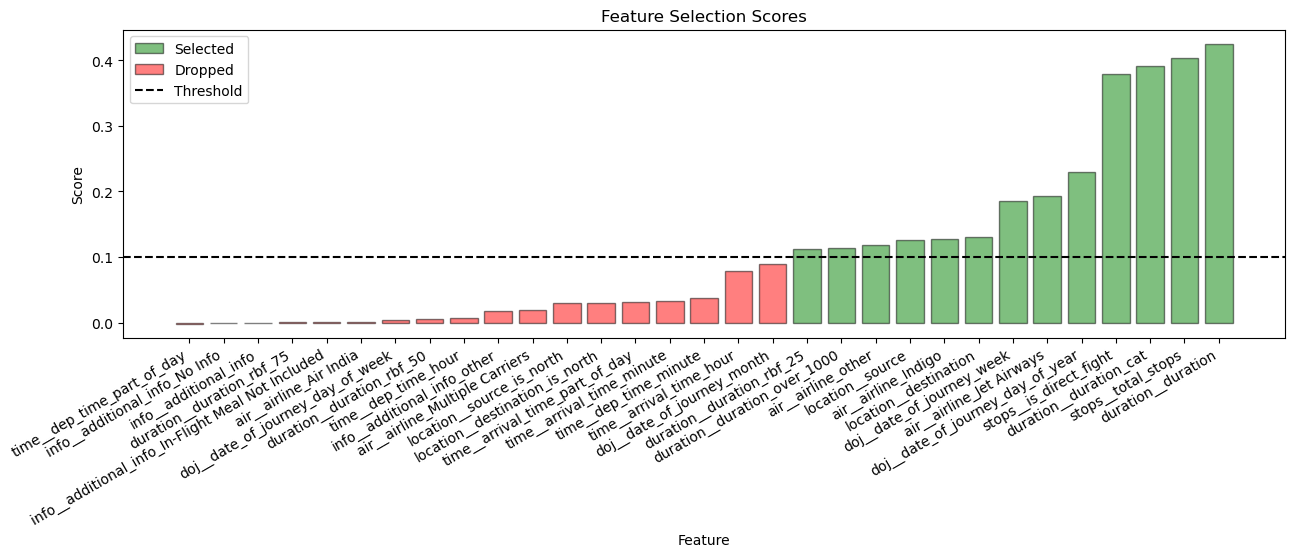

In [52]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()


- The dataset went upto 31 columns after feature engineering.
- The feature selection algorithm selected 13 features out of that.